# kaggle 比赛: M5 时序预测

### 项目背景
由预测专家[Spyros Makridakis](https://en.wikipedia.org/wiki/Makridakis_Competitions)组织的M竞赛，旨在通过比较在不同预测方法下解决现实问题的性能，从而更好地理解和改进预测方法。 第一届M比赛于1982年举行。第四届[M4比赛](https://www.sciencedirect.com/science/article/pii/S0169207019301128)于2018年举行，其特色是“ 100,000个时间序列和61种预测方法”。 根据预测研究人员和从业者[Rob Hyndman](https://robjhyndman.com/hyndsight/)所说，“M竞赛对预测领域产生了巨大影响。 他们将注意力集中在哪些模型产生了良好的预测，而不是那些模型的数学特性上。” 这种目的与Kaggle的目标非常相似，后者是最佳的机器学习社区，可以在各种数据集上进行激烈的竞争。 M5是在Kaggle举行的第一场M比赛。

### 项目目标  
本次竞赛的目的为预测零售巨头沃尔玛在未来28天提供的销售数据。除此以外，该数据还进行另一项预测不确定性的比赛，两项比赛的预测期相同，均为28天。

- [预测未来28天销售数据比赛](https://www.kaggle.com/c/m5-forecasting-accuracy/)
- [不确定性预测比赛](https://www.kaggle.com/c/m5-forecasting-uncertainty)

### 数据集
项目要求处理42,840个分层时间序列。 数据是从美国加利福尼亚州（CA）、德克萨斯州（TX）和威斯康星州（WI）3个州获得的。 这里的“分层”表示可以在不同级别上汇总数据：项目级别，部门级别，产品类别级别和州级别。 销售信息从2011年1月开始至2016年6月结束。除了销售数量，数据集还提供了有关价格、促销、节假日的相应数据。  

该数据包含来自3个类别和7个部门的3049种单独产品，分别在3个州的10家商店中销售。对层次进行聚合可以得到这些因素的组合。例如，我们可以为所有销售创建1个时间序列，为每个州所有销售创建3个时间序列，依此类推。 最大的类别是每10个商店的30490时间序列中所有3049个产品的销售额。

- `sales_train_validation.csv`这是主要训练数据。数据集时间从开始2011年1月29日至2016年5月22日，共有1941天；该数据集不包括截至2016年6月19日待预测的28天数据。 它还包括项目，部门，类别，商店和州的ID。 对于30490个项目和10个商店的所有组合，行数为30490。

- `sell_prices.csv`商店、商品ID、每周平均价格。

- `calendar.csv`日期以及相关的分类（例如星期几，月份，年份）和3个二进制列（用于表示每个州的商店在该日期是否允许购买SNAP券）。

- `sample_submission.csv`正确的提交格式。 有关更多信息，请参考[评估选项卡](https://www.kaggle.com/c/m5-forecasting-accuracy/overview/evaluation)。

### 评估指标
- 该预测使用加权均方根比例误差(RMSSE)进行评估，RMSSE由平均绝对比例误差[MASE](https://en.wikipedia.org/wiki/Mean_absolute_scaled_error)演化而来。

# 数据分析
## 加载库

In [1]:
# 加载基本库
import pandas as pd
import numpy as np
import sys
from  datetime import datetime, timedelta

# 加载可视化库
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
# 图标样式美化
plt.style.use('ggplot')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# import machine learning lib
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix
import gc

## 加载和清洗数据
### 数据压缩
> github免费版对上传数据有限制，不能上传大于100MB的文件，需要将原有数据集压缩，压缩格式使用bz2，在此格式下，python可以直接读取数据集。

- Mac OS下，通过Terminal使用以下命令压缩数据集

```shell
$ bzip2 -z sales_train_validation.csv
$ bzip2 -z sell_prices.csv
```

> **注意：使用此命令后会删除被压缩的文件**

### 加载与观察数据

In [2]:
sale_data = pd.read_csv('./m5-forecasting-accuracy/sales_train_validation.bz2')
cal_data = pd.read_csv('./m5-forecasting-accuracy/calendar.csv')
price_data = pd.read_csv('./m5-forecasting-accuracy/sell_prices.bz2')

In [3]:
sale_data.sample(10)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
4631,HOUSEHOLD_2_487_CA_2_validation,HOUSEHOLD_2_487,HOUSEHOLD_2,HOUSEHOLD,CA_2,CA,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
21755,HOBBIES_1_421_WI_1_validation,HOBBIES_1_421,HOBBIES_1,HOBBIES,WI_1,WI,0,0,0,0,...,1,0,2,0,0,0,2,1,0,0
6345,HOBBIES_1_255_CA_3_validation,HOBBIES_1_255,HOBBIES_1,HOBBIES,CA_3,CA,0,0,0,0,...,0,0,2,0,0,1,0,0,1,0
18055,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,98,85,47,56,...,80,78,102,54,67,57,59,80,100,75
28780,HOUSEHOLD_2_244_WI_3_validation,HOUSEHOLD_2_244,HOUSEHOLD_2,HOUSEHOLD,WI_3,WI,0,0,0,0,...,0,0,0,1,1,0,1,1,0,0
9753,HOUSEHOLD_1_044_CA_4_validation,HOUSEHOLD_1_044,HOUSEHOLD_1,HOUSEHOLD,CA_4,CA,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0
5799,FOODS_3_526_CA_2_validation,FOODS_3_526,FOODS_3,FOODS,CA_2,CA,8,8,0,0,...,8,13,16,6,7,11,5,10,15,15
9207,HOBBIES_1_062_CA_4_validation,HOBBIES_1_062,HOBBIES_1,HOBBIES,CA_4,CA,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
20911,FOODS_3_393_TX_3_validation,FOODS_3_393,FOODS_3,FOODS,TX_3,TX,0,0,0,0,...,4,4,6,6,6,10,3,1,0,3
26011,FOODS_1_009_WI_2_validation,FOODS_1_009,FOODS_1,FOODS,WI_2,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
sale_data.shape

(30490, 1919)

sales_train_validation为历史销售数据，通过该数据获得项目的部门、类别、州和商店ID，d_1至d_1913列为天数，内容为每天的销售额。  
根据比赛说明，需要评估的数据如下：
- d_1914-d_1941共28天数据作为验证集数据（A榜成绩评估标准）；  
- d_1942-d_1969共28天数据作为最终比赛排名的测试集数据（B榜成绩评估标准）。

**所有商品每天的销量**

In [5]:
# 汇总每天的总销量
day_data = sale_data[[f'd_{day}' for day in range(1,1914)]]
# 按列聚合销量
total_sum = np.sum(day_data,axis=0).values
total_sum.shape

(1913,)

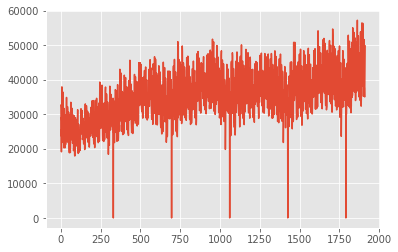

In [6]:
plt.plot(total_sum);

- 销量为0的天数周期性的出现
- 销量异常低的天数周期性的出现
- 销量整体呈增长趋势
- 两个0销量之间的销量趋势类似

**单个商品每天的销量**  
> 选择一个畅销的随机商品，查看其每天的销量的变化

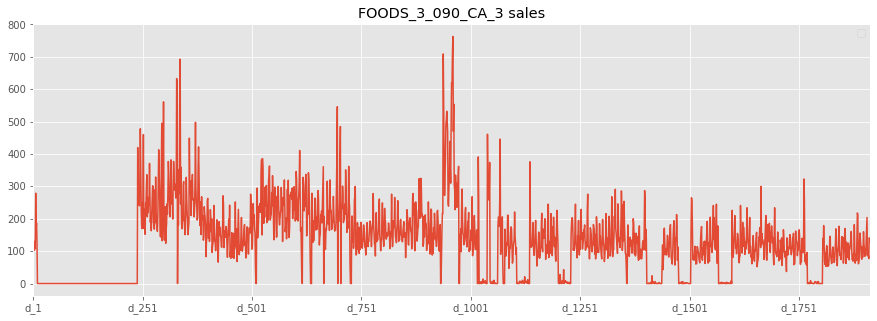

In [7]:
# 获得数据集的所有天数
day_cols = [day for day in sale_data.columns if 'd_' in day]
# 可视化‘FOODS_3_090_CA_3’这个商品每天的销量
sale_data.loc[sale_data['id'] == 'FOODS_3_090_CA_3_validation'] \
         .set_index('id')[day_cols] \
         .T \
         .plot(figsize=(15, 5),
               title='FOODS_3_090_CA_3 sales',
               color=next(color_cycle))
plt.legend('') # 因为只有一个商品，隐藏标签
plt.show()

In [8]:
# 将横坐标转换为日期
# 需要从日历数据'date'中获得日期
cal_data[['d','date','event_name_1','event_name_2','event_type_1','event_type_2', 'snap_CA']].sample(5)

,d,date,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA
580,d_581,2012-08-31,NaN,NaN,NaN,NaN,0
475,d_476,2012-05-18,NaN,NaN,NaN,NaN,0
1618,d_1619,2015-07-05,NaN,NaN,NaN,NaN,1
1285,d_1286,2014-08-06,NaN,NaN,NaN,NaN,1
211,d_212,2011-08-28,NaN,NaN,NaN,NaN,0


In [9]:
# 查看该商品的索引
sale_data[sale_data['id'] == 'FOODS_3_090_CA_3_validation']

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
8412,FOODS_3_090_CA_3_validation,FOODS_3_090,FOODS_3,FOODS,CA_3,CA,108,132,102,120,...,129,160,204,86,100,88,77,141,139,130


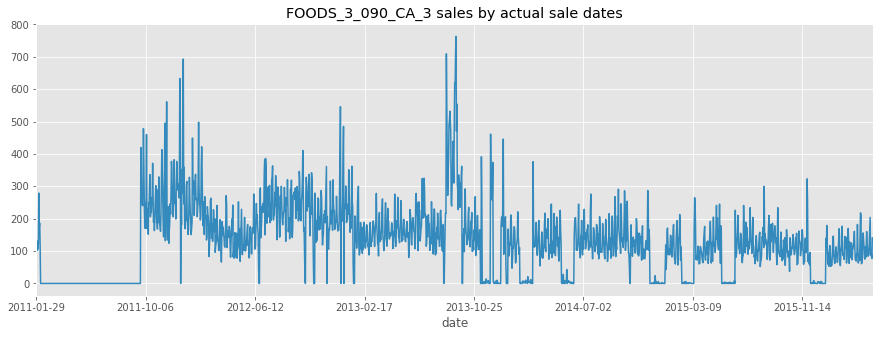

In [10]:
# 将之前转置数据的操作合并为一行代码
plot_eg_1 = sale_data.loc[sale_data['id'] == 'FOODS_3_090_CA_3_validation'][day_cols].T
# 转置之后的数据该商品名称是其索引号，需要改为商品名称
plot_eg_1 = plot_eg_1.rename(columns={8412:'FOODS_3_090_CA_3'})
# 以 d 为索引
plot_eg_1 = plot_eg_1.reset_index().rename(columns={'index': 'd'}) 
# 与日历数据合并
plot_eg_1 = plot_eg_1.merge(cal_data)
# 以日期为横坐标
plot_eg_1.set_index('date')['FOODS_3_090_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='FOODS_3_090_CA_3 sales by actual sale dates')
plt.show();

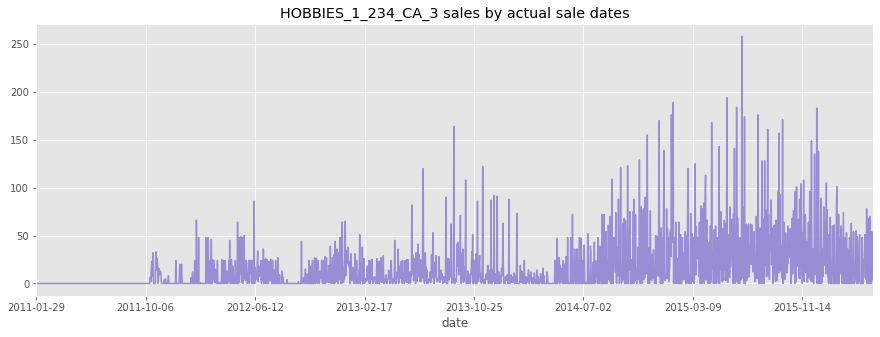

In [11]:
# 与其他畅销商品对比
plot_eg_2 = sale_data.loc[sale_data['id'] == 'HOBBIES_1_234_CA_3_validation'][day_cols].T
plot_eg_2 = plot_eg_2.rename(columns={6324:'HOBBIES_1_234_CA_3'}) 
plot_eg_2 = plot_eg_2.reset_index().rename(columns={'index': 'd'}) 
plot_eg_2 = plot_eg_2.merge(cal_data)
plot_eg_2.set_index('date')['HOBBIES_1_234_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='HOBBIES_1_234_CA_3 sales by actual sale dates')
plt.show();

- `FOODS_3_090_CA_3_validation`这件商品很畅销
- `HOBBIES_1_234_CA_3`商品销量不高
- `FOODS_3_090_CA_3_validation`在某些情况下几乎没有销量
- `HOBBIES_1_234_CA_3`在某些情况下畅销
- 2011年10月前，2件商品基本没有销量

**查看20种不同商品的销售情况**

In [12]:
# 随机获得20件商品的销量
twenty_egs = sale_data.sample(20, random_state=2) \
    .set_index('id')[day_cols] \
    .T \
    .merge(cal_data.set_index('d')['date'], 
            left_index=True ,
            right_index=True,
            validate='1:1') \
    .set_index('date')
twenty_egs.head()

,FOODS_3_505_CA_3_validation,HOBBIES_1_108_WI_2_validation,FOODS_3_587_CA_2_validation,HOBBIES_1_019_TX_2_validation,HOUSEHOLD_2_226_CA_4_validation,FOODS_2_251_TX_2_validation,HOUSEHOLD_2_291_TX_1_validation,FOODS_3_814_TX_2_validation,HOUSEHOLD_1_373_WI_3_validation,FOODS_3_717_TX_1_validation,FOODS_3_209_CA_2_validation,FOODS_3_722_TX_2_validation,HOUSEHOLD_1_469_CA_4_validation,HOUSEHOLD_2_233_TX_2_validation,HOBBIES_1_308_TX_3_validation,FOODS_3_587_TX_2_validation,HOBBIES_1_306_CA_3_validation,HOUSEHOLD_1_086_WI_3_validation,HOUSEHOLD_1_345_WI_2_validation,FOODS_3_115_CA_2_validation
date,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,4,0,0,0,5,0,0,44,0,0,0,1,0,0,59,0,5,2,2
2011-01-30,0,4,0,0,0,10,0,0,48,0,0,0,0,0,0,34,0,0,0,0
2011-01-31,0,3,0,0,2,2,0,0,16,0,0,0,0,1,0,37,0,0,0,1
2011-02-01,0,2,13,0,0,7,0,0,0,0,0,0,0,0,0,7,0,0,0,3
2011-02-02,0,1,25,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0


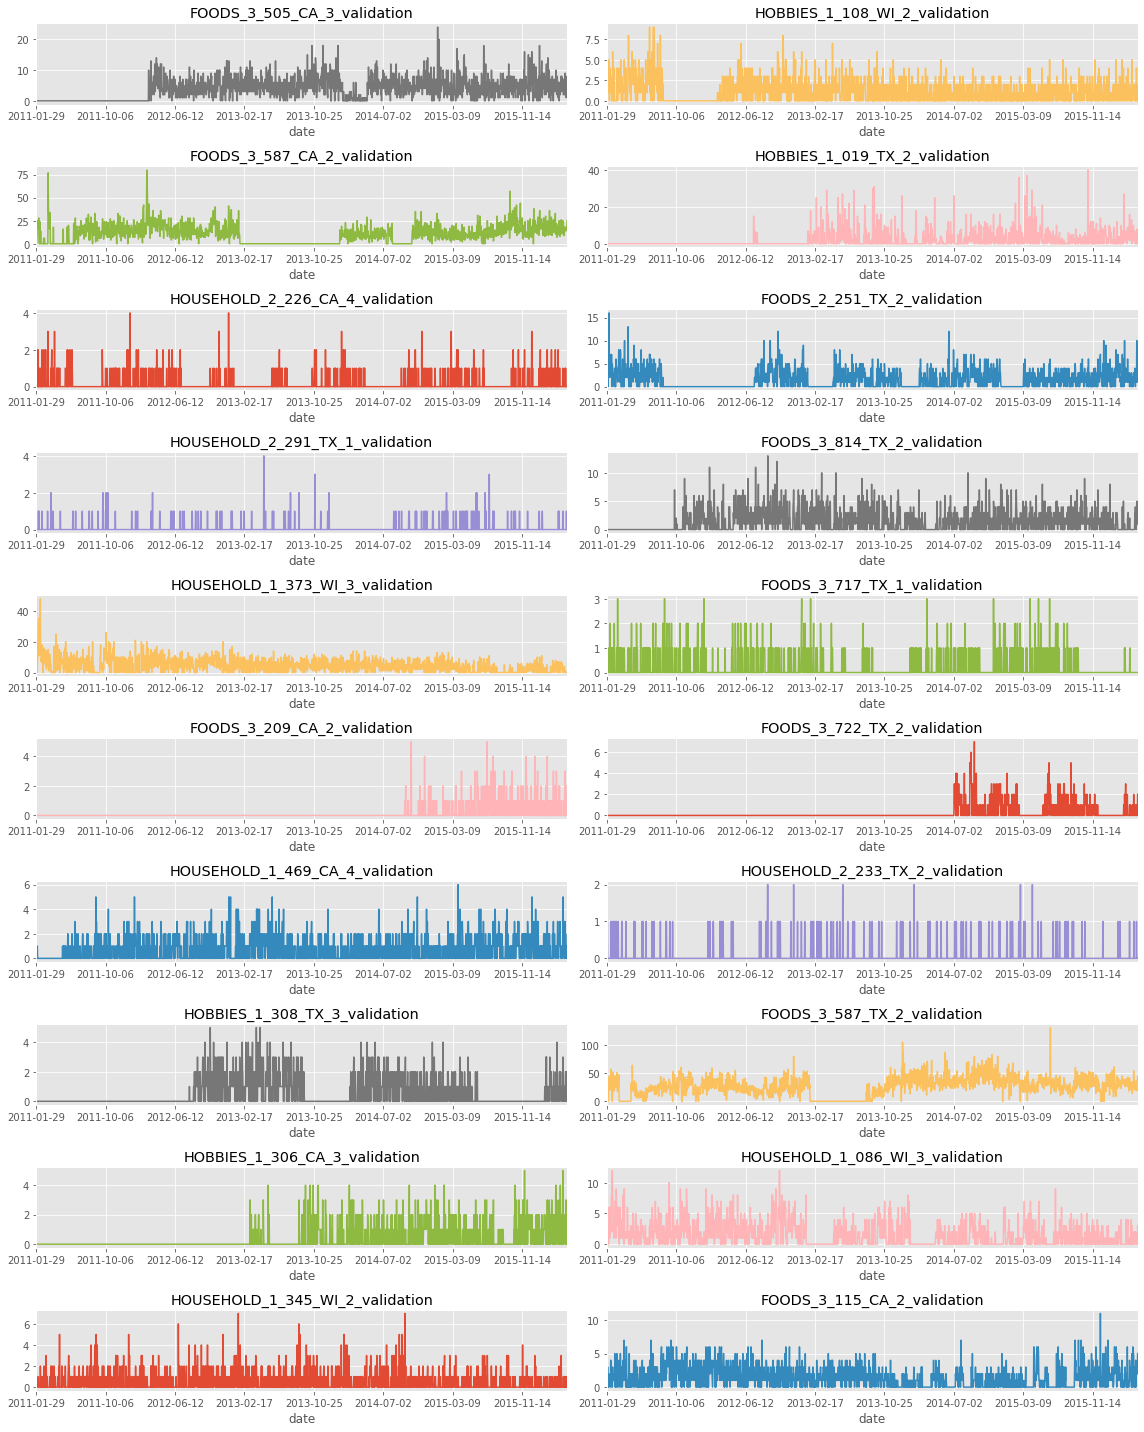

In [13]:
# 生成20种商品的销量图
fig, axs = plt.subplots(10, 2, figsize=(16, 20))
# .reshape(-1)与.flatten()的作用相同，均将ndarray数组转换为一维数组
axs = axs.reshape(-1)
ax_idx = 0
for item in twenty_egs.columns:
    twenty_egs[item].plot(title=item,
                          color=next(color_cycle),
                          ax=axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()

观察结果：
- 经常会看到一些产品长时间出现销量为0的情况
- 有些商品一天只卖1件或者没有销量，很难预测这些商品未来的销量
- 有些时间段以上所有商品销量均非常高，可能与某些全国性的活动或者节日有关

**按照商品类型分类，观察销量与时间的关系**  

In [14]:
item_type = sale_data['cat_id'].unique()
item_type

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

数据集中有几种商品类型：  
- 兴趣爱好
- 日常用品
- 食品  

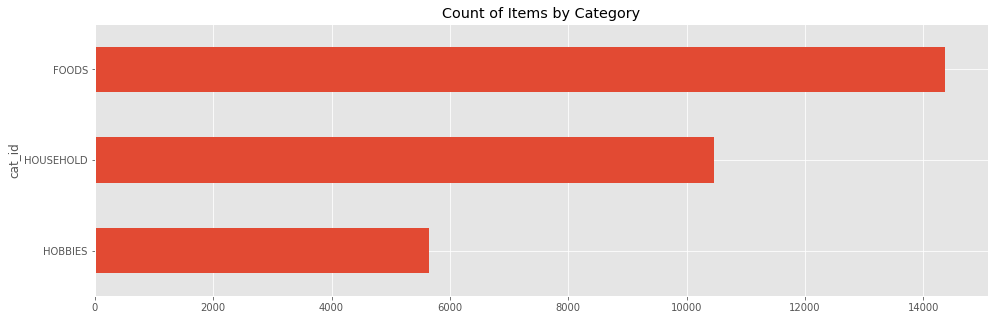

In [15]:
# 绘制每种类型随着时间，其总销量的变化
sale_data.groupby('cat_id').count()['id'] \
         .sort_values() \
         .plot(kind='barh', figsize=(16, 5), title='Count of Items by Category')
plt.show()

In [16]:
# 以时间为索引，所有商品为列，汇总销量
category_sales = sale_data.set_index('id')[day_cols] \
    .T \
    .merge(cal_data.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')

In [17]:
display(category_sales.info(), category_sales.head())

<class 'pandas.core.frame.DataFrame'>
Index: 1913 entries, 2011-01-29 to 2016-04-24
Columns: 30490 entries, HOBBIES_1_001_CA_1_validation to FOODS_3_827_WI_3_validation
dtypes: int64(30490)
memory usage: 445.0+ MB


None

,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,HOBBIES_1_010_CA_1_validation,...,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,...,0,6,1,0,5,2,0,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,...,0,5,1,0,2,0,0,2,0,0


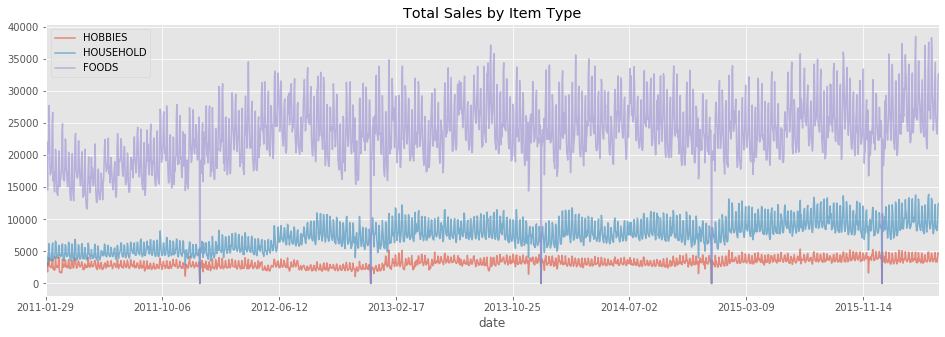

In [18]:
for i in sale_data['cat_id'].unique():
    items_col = [a for a in category_sales.columns if i in a]
    category_sales[items_col] \
        .sum(axis=1) \
        .plot(figsize=(16, 5),
              alpha=0.6,
              title='Total Sales by Item Type')
plt.legend(item_type)
plt.show()

观察结果：

- 食物分类的商品销量较其他两类，一直保持在最高的水平
- 兴趣爱好分类的商品总销量最低
- 在特定时间段，所有分类的商品销量都有下降，甚至没有销量

**按分店分组，观察销量与时间的关系**

In [19]:
store_list = price_data['store_id'].unique()
store_list

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

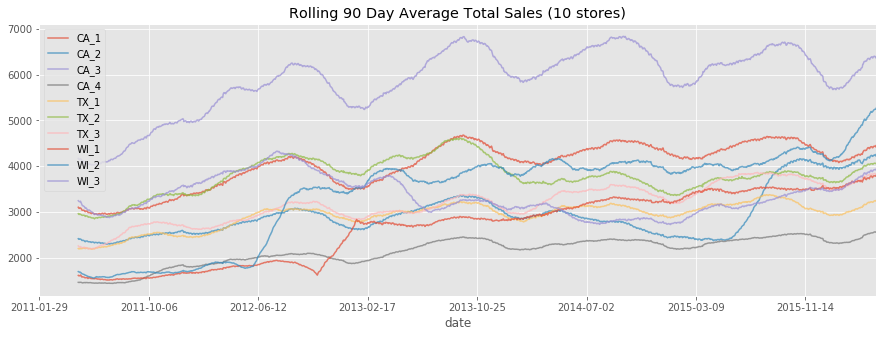

In [20]:
for s in store_list:
    store_items = [a for a in category_sales.columns if s in a]
    # 以时间为索引，按商品汇总销量
    store_items_temp = category_sales[store_items]
    # 获得每天的总销量
    store_items_temp_2 = store_items_temp.sum(axis=1)
    # 以时间为索引，滚动运算每90天销量的均值
    store_items_temp_3 = store_items_temp_2.rolling(90).mean()
    store_items_temp_3.plot(figsize=(15, 5), alpha=0.7, title='Rolling 90 Day Average Total Sales (10 stores)')
plt.legend(store_list)
plt.show()

观察结果：
- CA_3分店的销量最高
- CA_2、WI_2、WI_1分店销量均在一个时期发生很大波动
- 基本上所有分店总销量均呈增长趋势

**商品`FOODS_3_090`价格与时间的关系**

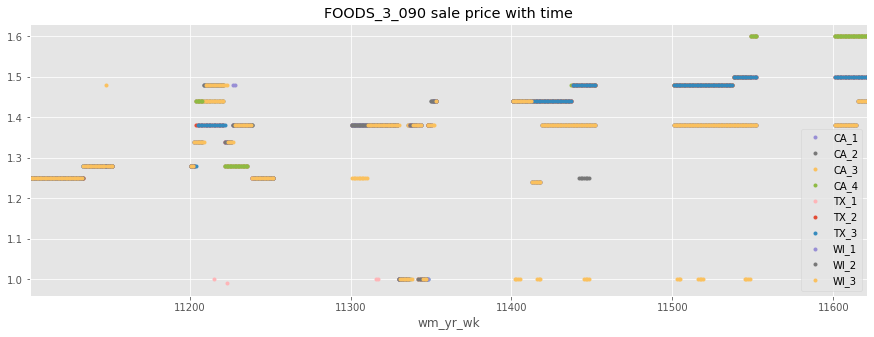

In [21]:
fig, ax = plt.subplots(figsize=(15, 5))

stores = []
# 遍历该商品在不同分店的价格，并画图
for store, d in price_data.query('item_id == "FOODS_3_090"').groupby('store_id'):
    stores.append(store)
    d.plot(x='wm_yr_wk',
          y='sell_price',
          style='.',
          color=next(color_cycle),
          title='FOODS_3_090 sale price with time',
          ax=ax,
          legend=store)
plt.legend(stores)
plt.show()

观察结果：

- 该商品随着时间的推移，价格在逐渐上升
- 有些时间该商品的价格会非常低
- 有些分店在同一时间，该商品价格是不同的

**预测值（label）分布**

In [22]:
# 查看待预测值
display(day_data.head(), day_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1913 entries, d_1 to d_1913
dtypes: int64(1913)
memory usage: 445.0 MB


,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,0,0,0,0,0,0,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,0,0,0,0,0,0,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


None

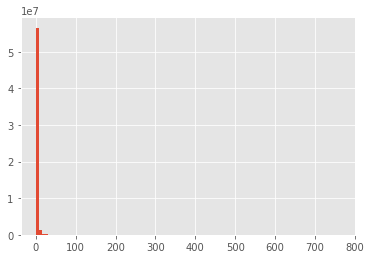

In [23]:
# 将包含所有数据的dataframe，先转换为ndarray数组，再转换为一维数组
day_data_single = day_data.values.flatten()
plt.hist(day_data_single,bins=100);

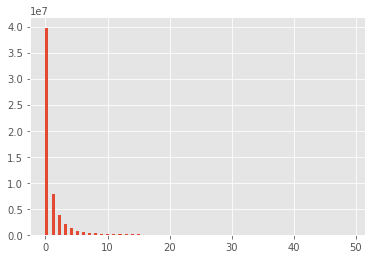

In [24]:
# 小于50的值占大多数，增加筛选条件后再次查看数据分布
plt.hist(day_data_single[day_data_single<50],bins=100);

观察结果：

- 大部分值为0
- 非正态分布

### 数据观察结论

- 所有分店销量呈周期性上升趋势
- 大量数据为0且为整数
- 按不同维度聚合，呈现不同趋势
- 非正态分布

---
## 特征工程

根据数据观察结论选定机器学习算法作为建模方案，思路是对时间序列抽取窗口特征。

### 抽取窗口特征思路

In [25]:
sale_data.head(1)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1


原始销量数据的每一行为1个时间序列，将原始的销量数据拆分为如下形式后，每天销量的表现形式发生较大的变化。  
表中`feature`左边的列均为机器学习建模中的一部分**特征**。  
因为需要预测未来的销量，每个时间序列的`label`对应第二天的销量。

![img](./image/baseline.png)

由于时间序列之间是关联的，所以需要窗口函数抽取一定时间范围内的销量，得到这段连续时间内销量的均值，再将均值作为**标签**，这就是利用窗口函数抽取特征的基本思路。

根据先前对数据的观察，销量存在周周期性与约周期性，可以使用窗口函数抽取以下特征：

- 前7天
- 前28天
- 前7天均值
- 前28天均值

需要关联其他维度的信息

- 日期
- 价格

In [26]:
# 创建训练数据集
def create_train_data(train_start=750,test_start=1800,is_train=True):
    '''
    参数说明：
    train_start   设置训练集取值范围，取值范围为变量值至最后一个时间序列之间所有数据。
    test_start    设置验证集取值范围，取值范围为变量值至最后一个时间序列之间所有数据。
    is_train=True 区分训练集与验证集条件。
    '''
    # 不同数据类型的特征，转化为可供机器学习运算的方式不同
    # 定义数据集中变量的数据类型
    PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }
    CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
            "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
            "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }

    start_day = train_start if is_train else test_start
    numcols = [f"d_{day}" for day in range(start_day,1914)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    SALE_DTYPES = {numcol:"float32" for numcol in numcols} 
    # id是数据主键，不能将其转换为category类型
    SALE_DTYPES.update({col: "category" for col in catcols if col != "id"})

    # 加载price数据，设置每列数据的类型
    price_data = pd.read_csv('./m5-forecasting-accuracy/sell_prices.bz2',dtype=PRICE_DTYPES)
    # 加载cal数据，设置每列数据的类型
    cal_data = pd.read_csv('./m5-forecasting-accuracy/calendar.csv',dtype=CAL_DTYPES)
    # 加载sale数据，设置每列数据的类型
    sale_data = pd.read_csv('./m5-forecasting-accuracy/sales_train_validation.bz2',dtype=SALE_DTYPES,usecols=catcols+numcols)

    # 转换price数据
    # 类别标签转换为线性代数矩阵
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            price_data[col] = price_data[col].cat.codes.astype("int16")
            # 确保不会出现小于0的值
            price_data[col] -= price_data[col].min()
    
    # 转换cal数据
    # 时间类型数据与其他数据类型不同，需要单独定义数据转换方式
    cal_data["date"] = pd.to_datetime(cal_data["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal_data[col] = cal_data[col].cat.codes.astype("int16")
            cal_data[col] -= cal_data[col].min()

    # 转换sale数据
    for col in catcols:
        if col != "id":
            sale_data[col] = sale_data[col].cat.codes.astype("int16")
            sale_data[col] -= sale_data[col].min()
    
    # 生成提交格式，保证训练集数据与测试集数据形状相同
    if not is_train:
        for day in range(1913+1, 1913+ 2*28 +1):
            sale_data[f"d_{day}"] = np.nan

    # 转置数据，将宽数据集转换为长数据集
    sale_data = pd.melt(sale_data,
            id_vars = catcols,
            value_vars = [col for col in sale_data.columns if col.startswith("d_")],
            var_name = "d",
            value_name = "sales")
    # 将cal数据、price数据与sale数据合并
    sale_data = sale_data.merge(cal_data, on= "d", copy = False)
    sale_data = sale_data.merge(price_data, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    return sale_data

In [27]:
# 抽取特征
def create_feature(sale_data, is_train=True, day=None):
    # 生成两列数据，一个是当天7天前的数据，另一个是当天28天前的数据
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]

    # 如果是测试集只需要计算一天的特征，减少计算量
    # 保证训练集和测试集特征生成一致
    if is_train:
        for lag, lag_col in zip(lags, lag_cols):
            sale_data[lag_col] = sale_data[["id","sales"]].groupby("id")["sales"].shift(lag)
    else:
        for lag, lag_col in zip(lags, lag_cols):
            sale_data.loc[sale_data.date == day, lag_col] = sale_data.loc[sale_data.date == day-timedelta(days=lag), 'sales'].values  


    # 生成四列数据，作为时间序列特征
    # 第一列数据是前7天的“前七天均值”
    # 第二列数据是前28天的“前七天均值”
    # 第三列数据是前7天的“前二十八天均值”
    # 第四列数据是前28天的“前二十八天均值”
    wins = [7, 28]

    if is_train:
        for win in wins :
            for lag,lag_col in zip(lags, lag_cols):
                sale_data[f"rmean_{lag}_{win}"] = sale_data[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())
    else:
        for win in wins:
            for lag in lags:
                df_window = sale_data[(sale_data.date <= day-timedelta(days=lag)) & (sale_data.date > day-timedelta(days=lag+win))]
                df_window_grouped = df_window.groupby("id").agg({'sales':'mean'}).reindex(sale_data.loc[sale_data.date==day,'id'])
                sale_data.loc[sale_data.date == day,f"rmean_{lag}_{win}"] = df_window_grouped.sales.values   

    # 有的时间特征没有值，通过datetime方法自动生成
    date_features = {
            "wday": "weekday",
            "week": "weekofyear",
            "month": "month",
            "quarter": "quarter",
            "year": "year",
            "mday": "day",
        }

    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in sale_data.columns:
            sale_data[date_feat_name] = sale_data[date_feat_name].astype("int16")
        else:
            sale_data[date_feat_name] = getattr(sale_data["date"].dt, date_feat_func).astype("int16")
    return sale_data

In [28]:
# 设置该次训练数据集参数
sale_data = create_train_data(train_start=1500,is_train=True)
sale_data = create_feature(sale_data)

# 清洗数据，选择需要训练的数据
sale_data.dropna(inplace=True)
# 分类类型特征
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id', 'event_name_1', 'event_name_2', 'event_type_1', 'event_type_2']
# 无需参与模型训练的变量
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
# 在训练集数据中剔除无需参与运算的变量
train_cols = sale_data.columns[~sale_data.columns.isin(useless_cols)]
# 特征数据
features_train = sale_data[train_cols]
# 标签数据
label_train = sale_data["sales"]

In [29]:
# 特征数据结果
display(features_train.head(), features_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10890174 entries, 1650761 to 12567123
Data columns (total 25 columns):
item_id         int16
dept_id         int16
store_id        int16
cat_id          int16
state_id        int16
wday            int16
month           int16
year            int16
event_name_1    int16
event_type_1    int16
event_name_2    int16
event_type_2    int16
snap_CA         float32
snap_TX         float32
snap_WI         float32
sell_price      float32
lag_7           float32
lag_28          float32
rmean_7_7       float32
rmean_28_7      float32
rmean_7_28      float32
rmean_28_28     float32
week            int16
quarter         int16
mday            int16
dtypes: float32(10), int16(15)
memory usage: 810.1 MB


,item_id,dept_id,store_id,cat_id,state_id,wday,month,year,event_name_1,event_type_1,...,sell_price,lag_7,lag_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
1650761,0,0,0,0,0,1,5,2015,0,0,...,8.26,2.0,2.0,0.857143,0.857143,0.750000,0.785714,18,2,2
1650762,0,0,0,0,0,2,5,2015,0,0,...,8.26,0.0,0.0,0.857143,0.571429,0.678571,0.785714,18,2,3
1650763,0,0,0,0,0,3,5,2015,0,0,...,8.26,1.0,0.0,0.857143,0.428571,0.678571,0.785714,19,2,4
1650764,0,0,0,0,0,4,5,2015,3,1,...,8.26,0.0,1.0,0.857143,0.571429,0.678571,0.821429,19,2,5
1650765,0,0,0,0,0,5,5,2015,0,0,...,8.26,0.0,2.0,0.571429,0.857143,0.678571,0.857143,19,2,6


None

In [30]:
# 标签数据结果
display(label_train.head(), label_train.shape)

1650761    1.0
1650762    2.0
1650763    0.0
1650764    0.0
1650765    0.0
Name: sales, dtype: float32

(10890174,)

## 三、模型训练


**[LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html)**是决策树算法中新的成员，该算法主要有以下优点：

- 比较容易理解
- 更快的训练效率
- 低内存使用
- 更高的准确率
- 支持并行化学习
- 可处理大规模数据
- 支持直接使用category特征

最近该算法在数据分析竞赛中出镜率非常高，特别适合个人参赛者使用，在有限的硬件条件下，可以得到不错的排名。

### LightGBM模型训练思路

**损失函数的选择**

虽然该比赛使用WRMSSE评估指标是从RMSE推导而来，但在EDA过程中发现标签数据非正态分布，不能使用MSE损失函数。  
标签数据呈现的分布与tweedie回归分布类似，故使用tweedie损失函数。（tweedie回归分布见下图）
<img src="./image/tweedie.png" style="width:300px;height:200px">


**预测时候的技巧**
- 直接使用tweedie损失函数并不能得到很好的结果，其与标签数据的分布还有一定区别，为了让损失函数分布更靠近实际数据分布，需要调整
`tweedie_variance_power`这个参数，该参数的范围在 [1,2] 之间。

> 参考:[怎么理解tweedie分布？](http://sofasofa.io/forum_main_post.php?postid=1004674)

- LightGBM 模型是决策树模型的变种，无法突破训练集的上界，然而销量随着时间序列呈上升趋势。这里解决该问题的办法为，在预测值上乘以一个值，放大预测出的结果。

In [31]:
# 训练模型
def train_model(train_data,valid_data):
    # 设置模型训练参数
    params = {
        "objective" : "tweedie",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
        "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        "metric": ["rmse"],
        "nthread": 8,
        # 调整该参数使tweedie分布更靠近实际标签数据分布
        "tweedie_variance_power":1.2,
        "verbosity": 1,
        "num_iterations" : 1500,
        "num_leaves": 128,
        "min_data_in_leaf": 104,
    }

    m_lgb = lgb.train(params, train_data, valid_sets = [valid_data], verbose_eval=50)

    return m_lgb

In [32]:
def predict_ensemble(train_cols,m_lgb):
    date = datetime(2016,4,25) 
    '''
    用三个不同的alpha值分别去预测28天的数据，再做平均
    每一轮28天的数据预测中用一个alpha值，在预测每天的数据之前会先取特征，特征中包含之前的时间数据
    这是一个迭代的预测过程
    '''
    # 设置三个不同alpha值并计算权重
    alphas = [1.028, 1.023, 1.018]
    weights = [1/len(alphas)]*len(alphas)
    sub = 0.

    test_data = create_train_data(is_train=False)
    # 循环使用不同的alpha值与权重预测数据
    for icount, (alpha, weight) in enumerate(zip(alphas, weights)):

        test_data_c = test_data.copy()
        cols = [f"F{i}" for i in range(1,29)]


        for i in range(0, 28):
            day = date + timedelta(days=i)
            print(i, day)
            tst = test_data_c[(test_data_c.date >= day - timedelta(days=57)) & (test_data_c.date <= day)].copy()
            # 这里运用了 create_feature 方法中设置测试集的天数范围
            tst = create_feature(tst,is_train=False, day=day)
            tst = tst.loc[tst.date == day , train_cols]

            test_data_c.loc[test_data_c.date == day, "sales"] = alpha*m_lgb.predict(tst)

        # 将结果转换为提交数据的格式
        test_sub = test_data_c.loc[test_data_c.date >= date, ["id", "sales"]].copy()
        test_sub["F"] = [f"F{rank}" for rank in test_sub.groupby("id")["id"].cumcount()+1]
        test_sub = test_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
        test_sub.fillna(0., inplace = True)
        test_sub.sort_values("id", inplace = True)
        test_sub.reset_index(drop=True, inplace = True)
        test_sub.to_csv(f"submission_{icount}.csv",index=False)
        if icount == 0 :
            sub = test_sub
            sub[cols] *= weight
        else:
            sub[cols] += test_sub[cols]*weight
        print(icount, alpha, weight)
    
    sub2 = sub.copy()
    # 把大于28天后的 validation 替换成 evaluation
    sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
    sub = pd.concat([sub, sub2], axis=0, sort=False)
    sub.to_csv("submissionV3.csv",index=False)

In [33]:
# 训练模型，并生成结果
train_data = lgb.Dataset(features_train, label = label_train, categorical_feature=cat_feats, free_raw_data=False)
valid_inds = np.random.choice(len(features_train), 10000)
valid_data = lgb.Dataset(features_train.iloc[valid_inds], label = label_train.iloc[valid_inds],categorical_feature=cat_feats, free_raw_data=False) 

m_lgb = train_model(train_data,valid_data) 
predict_ensemble(train_cols,m_lgb)

E:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
E:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[50]	valid_0's rmse: 2.09773
[100]	valid_0's rmse: 2.05376
[150]	valid_0's rmse: 2.03596
[200]	valid_0's rmse: 2.0207
[250]	valid_0's rmse: 1.97621
[300]	valid_0's rmse: 1.94877
[350]	valid_0's rmse: 1.92822
[400]	valid_0's rmse: 1.91431
[450]	valid_0's rmse: 1.89967
[500]	valid_0's rmse: 1.8815
[550]	valid_0's rmse: 1.87564
[600]	valid_0's rmse: 1.85932
[650]	valid_0's rmse: 1.85127
[700]	valid_0's rmse: 1.84451
[750]	valid_0's rmse: 1.83819
[800]	valid_0's rmse: 1.83273
[850]	valid_0's rmse: 1.82762
[900]	valid_0's rmse: 1.82133
[950]	valid_0's rmse: 1.81069
[1000]	valid_0's rmse: 1.80276
[1050]	valid_0's rmse: 1.79664
[1100]	valid_0's rmse: 1.78617
[1150]	valid_0's rmse: 1.783
[1200]	valid_0's rmse: 1.77698
[1250]	valid_0's rmse: 1.77038
[1300]	valid_0's rmse: 1.76436
[1350]	valid_0's rmse: 1.76023
[1400]	valid_0's rmse: 1.75342
[1450]	valid_0's rmse: 1.7471
[1500]	valid_0's rmse: 1.73823
0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-